# **TRAINING**

In [1]:
# Import necessary libraries
import os
import warnings
import logging
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import Model as tfkModel
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import register_keras_serializable
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from keras.callbacks import Callback
import IPython.display as display
from PIL import Image
import matplotlib.gridspec as gridspec
import json
import keras_cv
from tqdm import tqdm

In [2]:
# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

## **DISTRIBUTION DEFINITIONS**

In [3]:
def auto_select_accelerator():
    """
    Reference:
        * https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
        * https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
    """
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")

    return strategy

In [4]:
# Setting che correct strategy for TPU / batch sizes
strategy = auto_select_accelerator()
numGPU = len(tf.config.list_physical_devices('GPU'))
numTPU = len(tf.config.list_logical_devices('TPU'))
print("Num GPUs Available: ", numGPU)
print("Num TPUs Available: ", numTPU)

Running on 1 replicas
Num GPUs Available:  1
Num TPUs Available:  0


In [5]:
batch_size = 8
if numTPU != 0:
    batch_size = strategy.num_replicas_in_sync * 32

print(f"Batch size: {batch_size}")

Batch size: 8


## **DATA PREPROCESSING**

### Loading data

In [6]:
images_path = '/kaggle/input/lung-cancer/lung_dataset_interpolated.npz'
bboxes_path = '/kaggle/input/segmented-lung-cancer/bounding_boxes_new.npz'

In [7]:
def load_images(images_path=images_path): 
    data = np.load(images_path)
    slices = data['full_slices']
    labels = data['tumor_classes']

    return slices, labels

def load_bboxes(bboxes_path=bboxes_path):
    data = np.load(bboxes_path)
    return data['bounding_boxes']

In [8]:
full_slices, labels = load_images()
bboxes = load_bboxes()

In [9]:
print(full_slices.shape, labels.shape)
print(bboxes.shape)

(2363, 512, 512) (2363,)
(2363, 4)


In [10]:
from matplotlib.patches import Rectangle

def plot_image(full_slice = full_slices[0], 
               box = bboxes[0], 
               label = labels[0]):

    f, ax1 = plt.subplots(1, 1, figsize=(10, 10)) 
    f.suptitle(f"Severity class: {label}") 
    
    ax1.imshow(full_slice, cmap='gray')
    rect = Rectangle((box[0], box[1]), box[2], box[3], edgecolor='r', facecolor='none') 
    ax1.add_patch(rect)
    
    plt.show()

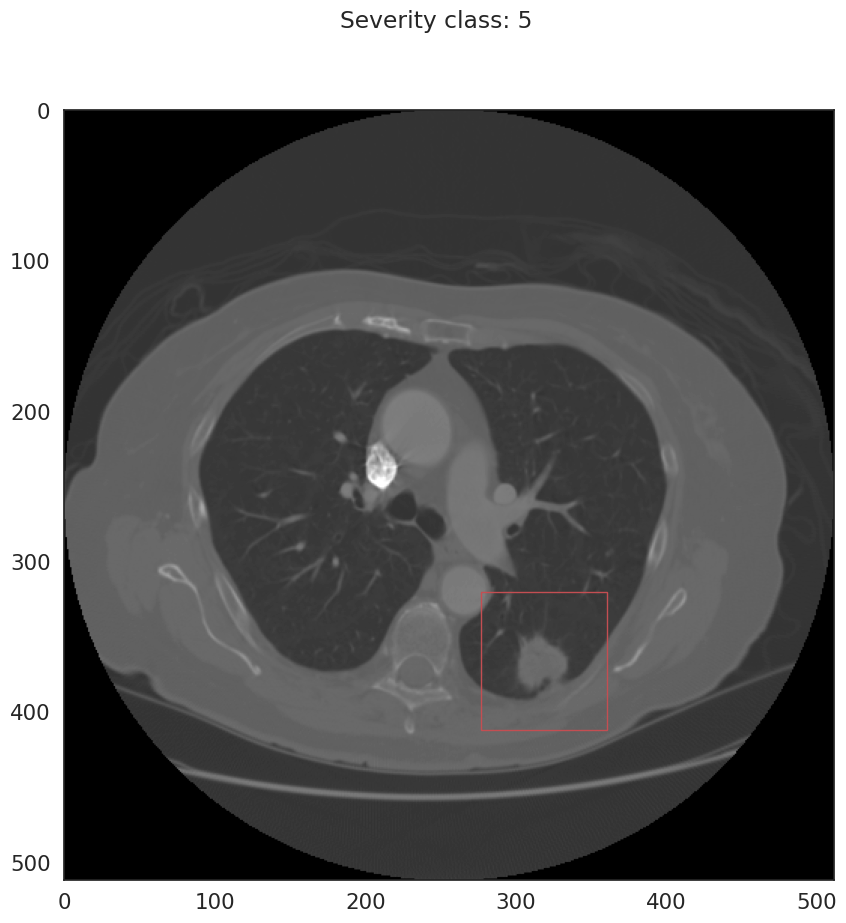

In [11]:
plot_image()

### Enhancing images

In [12]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) -  np.min(x))

In [13]:
import cv2 as cv

clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
kernel = np.ones((3, 3), np.uint8)

def img_enhancer(img):
    img = cv.medianBlur(img, 3)
    img = cv.equalizeHist(img)
    img = clahe.apply(img)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    return img

def img_enhancer_logger(img):
    def plot_image(image, title='Image'):
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

    plot_image(img)
    img = cv.medianBlur(img, 3)
    plot_image(img)
    img = cv.equalizeHist(img)
    plot_image(img)
    img = clahe.apply(img)
    plot_image(img)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    plot_image(img)
    img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    plot_image(img)
    return img

In [14]:
processed_images = []

for img in full_slices:
    img = img_enhancer(np.ceil(normalize(img)*255).astype("uint8"))
    processed_images.append(img)

full_slices = np.array(processed_images)

/tmp/ipykernel_30/3653980894.py:2: RuntimeWarning: overflow encountered in scalar subtract
  return (x - np.min(x)) / (np.max(x) -  np.min(x))


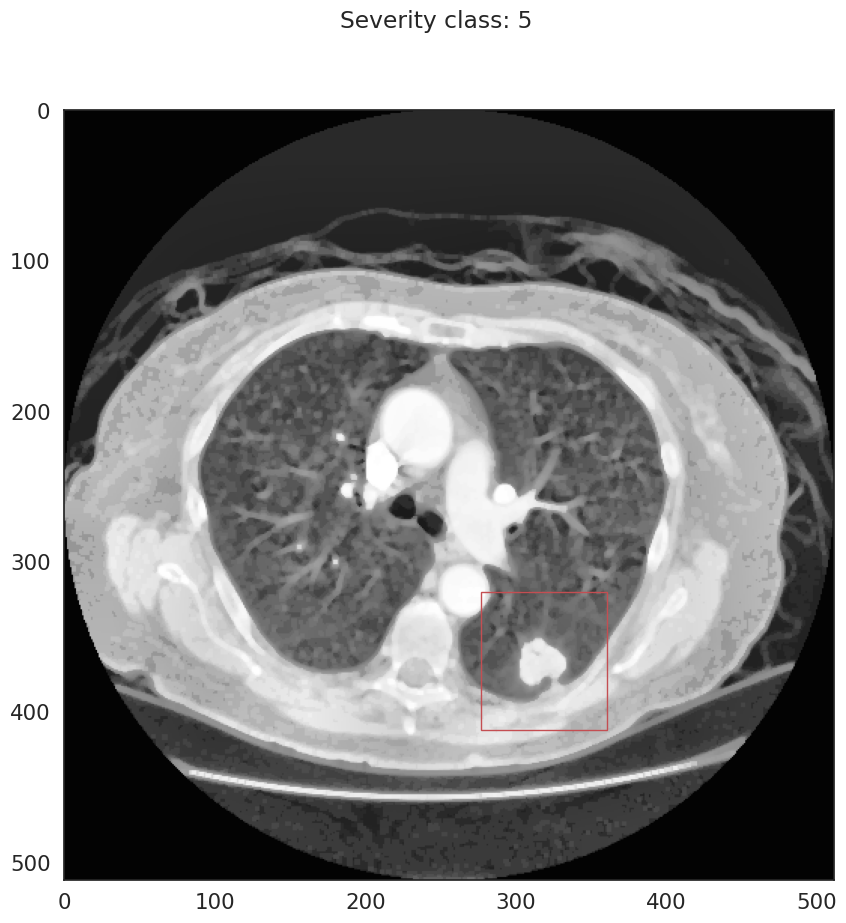

In [15]:
plot_image(full_slice = full_slices[0], 
           box = bboxes[0], 
           label = labels[0])

In [16]:
print("Range of images:")
print(f"{np.max(full_slices[0])}, {np.min(full_slices[0])}")

Range of images:
255, 3


### Preprocess boxes

In [17]:
size = full_slices[0].shape[0]
bboxes = bboxes.astype(float)  

# Normalize bboxes
bboxes /= size

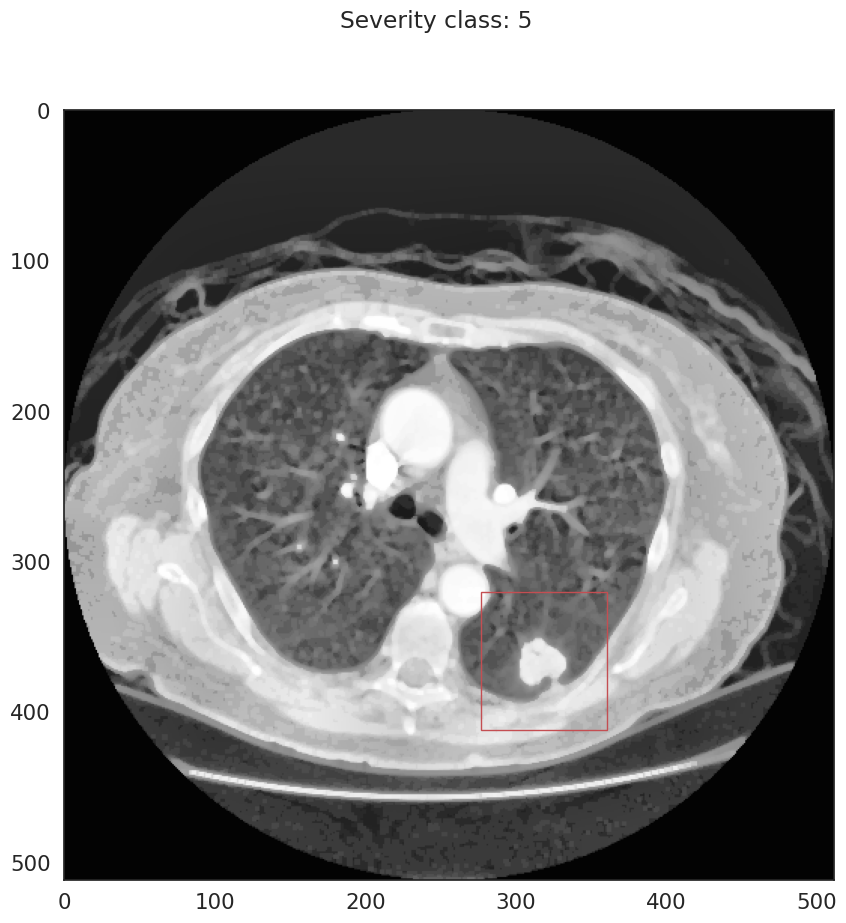

In [18]:
plot_image(full_slice = full_slices[0], 
           box = bboxes[0]*size, 
           label = labels[0])

### Creating datasets

In [19]:
SPLITS_SIZE = 300

In [20]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
X_train, X_val, y_train, y_val = train_test_split(
    full_slices, bboxes, test_size=SPLITS_SIZE 
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")

Splitting data...
Data splitted!

Number of images:
Train: 2063
Validation: 300


In [21]:
def load_single_image(image, bbox):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.cast(image, tf.float32) / 255.0

    # Read and preprocess the label
    bbox = tf.cast(bbox, tf.float32)

    return image, bbox

In [22]:
def make_dataset(image_paths, bbox_paths, batch_size, shuffle = True):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, bbox_paths)).cache()

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [23]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=batch_size,
    shuffle=True,
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=batch_size,
    shuffle=True
)
print("Datasets created!")

# Check the shape of the data
for images, bboxes in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Bboxes shape:", bboxes.shape)
    print("Bboxes dtype:", bboxes.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (512, 512, 3)
Images shape: (8, 512, 512, 3)
Bboxes shape: (8, 4)
Bboxes dtype: <dtype: 'float32'>


## **MODEL DEFINITION**

### Callbacks

In [24]:
# Custom callback class for real-time plotting
class RealTimePlot(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists that will store the metrics
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_iou = []
        self.val_iou = []

        # Set up the plot
        self.fig, (self.ax_loss, self.ax_iou) = plt.subplots(1, 2, figsize=(14, 5))
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        # Append the metrics to the lists
        self.epochs.append(epoch)
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.train_iou.append(logs.get('iou_metric'))
        self.val_iou.append(logs.get('val_iou_metric'))

        # Clear the previous output
        display.clear_output(wait=True)

        # Plot training and validation loss
        self.ax_loss.clear()
        self.ax_loss.plot(self.epochs, self.train_loss, label='Training Loss')
        self.ax_loss.plot(self.epochs, self.val_loss, label='Validation Loss')
        self.ax_loss.set_title('Training and Validation Loss')
        self.ax_loss.set_xlabel('Epoch')
        self.ax_loss.set_ylabel('Loss')
        self.ax_loss.legend()

        # Plot training and validation IoU
        self.ax_iou.clear()
        self.ax_iou.plot(self.epochs, self.train_iou, label='Training IoU')
        self.ax_iou.plot(self.epochs, self.val_iou, label='Validation IoU')
        self.ax_iou.set_title('Training and Validation IoU')
        self.ax_iou.set_xlabel('Epoch')
        self.ax_iou.set_ylabel('IoU')
        self.ax_iou.legend()

        # Redraw the updated plots
        display.display(self.fig)
        plt.pause(0.1)


In [25]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min', 
    patience=50,
    restore_best_weights=True
)

In [26]:
# Custom implementation of ReduceLROnPlateau
class CustomReduceLROnPlateau(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', factor=0.33, patience=20, min_lr=1e-8, verbose=1):
        super(CustomReduceLROnPlateau, self).__init__()
        self.monitor = monitor
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose
        self.wait = 0
        self.best = None
        self.new_lr = None

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        
        # Initialize best metric if it's the first epoch
        if self.best is None:
            self.best = current
            return

        # Check if the monitored metric has improved
        if current > self.best:
            self.best = current
            self.wait = 0
        else:
            self.wait += 1

            # If patience is exceeded, reduce the learning rate
            if self.wait >= self.patience:
                old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
                if old_lr == self.min_lr:
                    return
                self.new_lr = max(old_lr * self.factor, self.min_lr)
                self.model.optimizer.learning_rate.assign(self.new_lr)
                
                if self.verbose > 0:
                    print(f"\nEpoch {epoch + 1}: reducing learning rate to {self.new_lr}.")
                
                self.wait = 0  # Reset patience counter

In [27]:

# Visualization callback for object localization
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, bbox, frequency=1, output_dir='visualizations'):
        """
        Args:
            image: The image tensor or array.
            bbox: The ground truth bounding box in the format [x_min, y_min, x_max, y_max].
            frequency: Frequency (in epochs) at which to perform the visualization.
            output_dir: Directory where the visualizations will be saved.
        """
        super().__init__()
        self.image = image
        self.bbox = bbox
        self.frequency = frequency
        self.output_dir = output_dir

    def on_epoch_end(self, epoch, logs=None):
        # Visualize only every "frequency" epochs
        if epoch % self.frequency == 0:
            # Load the image and ground truth bounding box
            image, gt_bbox = load_single_image(self.image, self.bbox)
            # Expand dimensions to create a batch of size 1
            image_batch = tf.expand_dims(image, axis=0)
            # Get the predicted bounding box; assumes model outputs shape (1, 4)
            pred_bbox = self.model.predict(image_batch, verbose=0)[0]

            # Prepare directory for saving visualizations
            epoch_dir = os.path.join(self.output_dir, f"Epoch{epoch}")
            os.makedirs(epoch_dir, exist_ok=True)

            gt_bbox *= size
            pred_bbox *= size

            plt.figure(figsize=(18, 6))

            # Plot 1: Image with ground truth bounding box
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            ax = plt.gca()
            gt_rect = plt.Rectangle(
                (gt_bbox[0], gt_bbox[1]),
                gt_bbox[2],
                gt_bbox[3],
                fill=False,
                edgecolor='green',
                linewidth=4
            )
            ax.add_patch(gt_rect)
            plt.title("Ground Truth Bounding Box")
            plt.axis('off')

            # Plot 2: Image with predicted bounding box
            plt.subplot(1, 3, 2)
            plt.imshow(image)
            ax = plt.gca()
            pred_rect = plt.Rectangle(
                (pred_bbox[0], pred_bbox[1]),
                pred_bbox[2],
                pred_bbox[3],
                fill=False,
                edgecolor='red',
                linewidth=4
            )
            ax.add_patch(pred_rect)
            plt.title("Predicted Bounding Box")
            plt.axis('off')

            # Plot 3: Image with both bounding boxes overlaid
            plt.subplot(1, 3, 3)
            plt.imshow(image)
            ax = plt.gca()
            # Ground truth in green
            ax.add_patch(plt.Rectangle(
                (gt_bbox[0], gt_bbox[1]),
                gt_bbox[2],
                gt_bbox[3],
                fill=False,
                edgecolor='green',
                linewidth=4
            ))
            # Prediction in red
            ax.add_patch(plt.Rectangle(
                (pred_bbox[0], pred_bbox[1]),
                pred_bbox[2],
                pred_bbox[3],
                fill=False,
                edgecolor='red',
                linewidth=4
            ))
            plt.title("GT (Green) vs Prediction (Red)")
            plt.axis('off')

            plt.tight_layout()
            visualization_path = os.path.join(epoch_dir, "visualization.png")
            plt.savefig(visualization_path)
            plt.show()
            plt.close()

In [28]:
reduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
                                            monitor="val_loss",
                                            factor=0.5,
                                            patience=50,
                                            verbose=0,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=0,
                                            min_lr=0.0,
                                        )

plot_callback = RealTimePlot()
viz_callback = VizCallback(X_val[100], y_val[100])

### Loss

In [29]:
def iou_metric(y_true, y_pred):
    """
    Computes the Intersection over Union (IoU) between the true and predicted bounding boxes.
    Assumes boxes are in the format [x_min, y_min, x_max, y_max].
    """
    # Compute the coordinates of the intersection box
    x_min_inter = tf.maximum(y_true[..., 0], y_pred[..., 0])
    y_min_inter = tf.maximum(y_true[..., 1], y_pred[..., 1])
    x_max_inter = tf.minimum(y_true[..., 2], y_pred[..., 2])
    y_max_inter = tf.minimum(y_true[..., 3], y_pred[..., 3])

    # Compute the area of intersection rectangle
    inter_width = tf.maximum(0.0, x_max_inter - x_min_inter)
    inter_height = tf.maximum(0.0, y_max_inter - y_min_inter)
    intersection = inter_width * inter_height

    # Compute the area of both the predicted and ground-truth boxes
    area_true = (y_true[..., 2] - y_true[..., 0]) * (y_true[..., 3] - y_true[..., 1])
    area_pred = (y_pred[..., 2] - y_pred[..., 0]) * (y_pred[..., 3] - y_pred[..., 1])

    # Compute the union area
    union = area_true + area_pred - intersection

    # Compute the IoU, add a small epsilon to avoid division by zero
    iou = intersection / (union + 1e-7)
    return iou

In [30]:
def iou_loss(y_true, y_pred):
    """
    IoU loss function to minimize (1 - IoU).
    """
    return 1 - iou_metric(y_true, y_pred)

### Model

In [31]:
def inception_block(inputs, filters, name):
    f1, f3, f5, fpool = filters

    # 1x1 convolution
    conv_1x1 = tfkl.Conv2D(f1, kernel_size=1, activation='relu', name=f"{name}_1x1_conv")(inputs)

    # 3x3 convolution
    conv_3x3 = tfkl.Conv2D(f3, kernel_size=3, padding='same', activation='relu', name=f"{name}_3x3_conv")(inputs)
    
    # 5x5 convolution
    # conv_5x5 = tfkl.Conv2D(f5, kernel_size=5, padding='same', activation='relu', name=f"{name}_5x5_conv")(inputs)

    # Max pooling followed by 1x1 convolution
    max_pool = tfkl.MaxPooling2D(pool_size=3, strides=1, padding='same', name=f"{name}_max_pool")(inputs)
    max_pool = tfkl.Conv2D(fpool, kernel_size=1, activation='relu', name=f"{name}_pool_1x1_conv")(max_pool)

    # Concatenate all outputs
    output = tfkl.Concatenate(name=f"{name}_concat")([conv_1x1, conv_3x3, max_pool])
    return output

In [32]:
def create_localization_model(input_shape = full_slices.shape[1:]):
    """
    Creates and compiles a Keras model for object localization.
    
    Parameters:
      input_shape: tuple, the shape of the input image (height, width, channels).
    
    Returns:
      A compiled Keras model.
    """
    inputs = tfkl.Input(shape=input_shape)

    # Example convolutional base
    x = tfkl.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tfkl.MaxPooling2D((2, 2))(x)
    x = tfkl.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.MaxPooling2D((2, 2))(x)
    x = tfkl.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.MaxPooling2D((2, 2))(x)
    
    # Flatten and add fully connected layers
    x = tfkl.GlobalAveragePooling2D()(x)
    x = tfkl.Dense(256, activation='relu')(x)
    x = tfkl.Dense(128, activation='relu')(x)
    
    # Output layer with 4 units (for the bounding box coordinates)
    outputs = tfkl.Dense(4, activation='linear')(x)
    
    # Create the model
    model = tfk.models.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model with the custom IoU loss and IoU metric
    model.compile(optimizer=tfk.optimizers.AdamW(),
                  loss='mse',
                  metrics=['mse'])
    
    return model


In [33]:
def create_localization_model(input_shape = full_slices.shape[1:]):
    filters=(64, 64, 128, 256)
    f1, f2, f3, f4 = filters

    inputs = tfkl.Input(shape=input_shape, name='input')

    # Initial convolution
    x = tfkl.Conv2D(f1, kernel_size=3, activation='relu', name="conv_initial")(inputs)
    x = tfkl.MaxPooling2D(name="max_pool_initial")(x)

    # Inception block 1
    x = tfkl.Conv2D(f1, kernel_size=1, activation='relu', name="reduce_channels_2")(x)
    x = tfkl.Dropout(0.3, name="dropout_2")(x)
    x = inception_block(x, [f1, f2, f3, f4], name="inception_1")
    x = tfkl.SpatialDropout2D(0.2, name="spatial_dropout_1")(x)

    # Inception block 2
    x = tfkl.Conv2D(f3, kernel_size=1, activation='relu', name="reduce_channels_3")(x)
    x = tfkl.Dropout(0.4, name="dropout_3")(x)
    x = inception_block(x, [f2, f3, f4, f1], name="inception_2")
    x = tfkl.SpatialDropout2D(0.3, name="spatial_dropout_2")(x)

    # Global pooling and final classification
    x = tfkl.GlobalAveragePooling2D(name="global_avg_pooling")(x)
    x = tfkl.Dense(256, activation="silu")(x)
    x = tfkl.Dropout(0.4)(x)
    outputs = tfkl.Dense(4, activation="linear", name="output")(x)

    # Create the model
    model = tfk.models.Model(inputs=inputs, outputs=outputs)
    
    # Compile the model with the custom IoU loss and IoU metric
    model.compile(optimizer=tfk.optimizers.AdamW(),
                  loss='mse',
                  metrics=['mse'])
    
    return model


In [34]:
with strategy.scope():
    model = create_localization_model()
    model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 512, 512,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_initial        │ (None, 510, 510,  │      1,792 │ input[0][0]       │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pool_initial    │ (None, 255, 255,  │          0 │ conv_initial[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduce_channels_2   │ (None, 255, 255,  │      4,160 │ max_pool_initial… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 255, 255,  │          0 │ reduce_channels_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_1_max_po… │ (None, 255, 255,  │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_1_1x1_co… │ (None, 255, 255,  │      4,160 │ dropout_2[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_1_3x3_co… │ (None, 255, 255,  │     36,928 │ dropout_2[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_1_pool_1… │ (None, 255, 255,  │     16,640 │ inception_1_max_… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_1_concat  │ (None, 255, 255,  │          0 │ inception_1_1x1_… │
│ (Concatenate)       │ 384)              │            │ inception_1_3x3_… │
│                     │                   │            │ inception_1_pool… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout_1   │ (None, 255, 255,  │          0 │ inception_1_conc… │
│ (SpatialDropout2D)  │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduce_channels_3   │ (None, 255, 255,  │     49,280 │ spatial_dropout_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 255, 255,  │          0 │ reduce_channels_… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_2_max_po… │ (None, 255, 255,  │          0 │ dropout_3[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_2_1x1_co… │ (None, 255, 255,  │      8,256 │ dropout_3[0][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_2_3x3_co… │ (None, 255, 255,  │    147,584 │ dropout_3[0][0]   │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 343,876 (1.31 MB)

 Trainable params: 343,876 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

## **MODEL TRAINING**

In [35]:
EPOCHS = 200

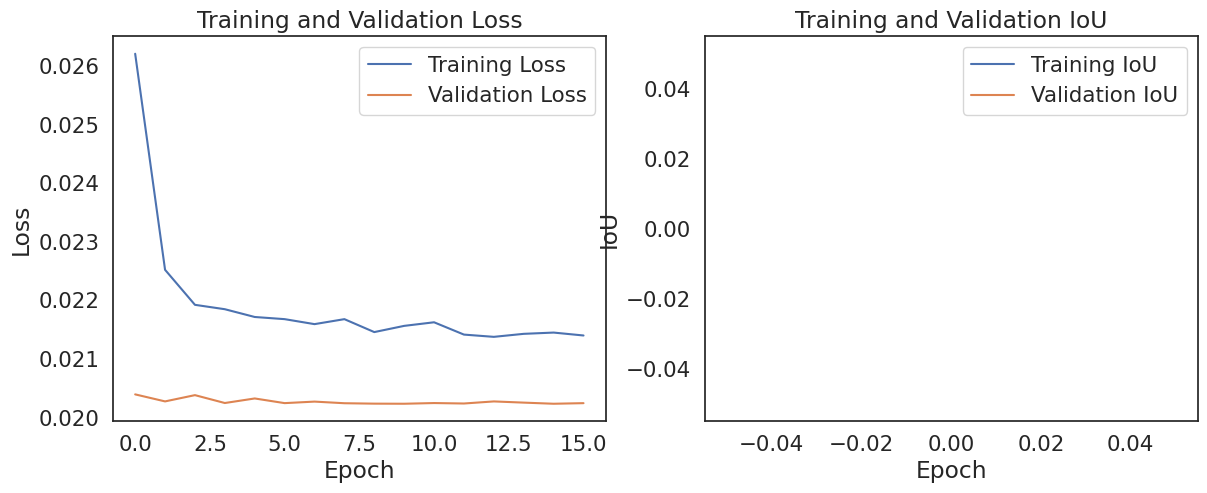

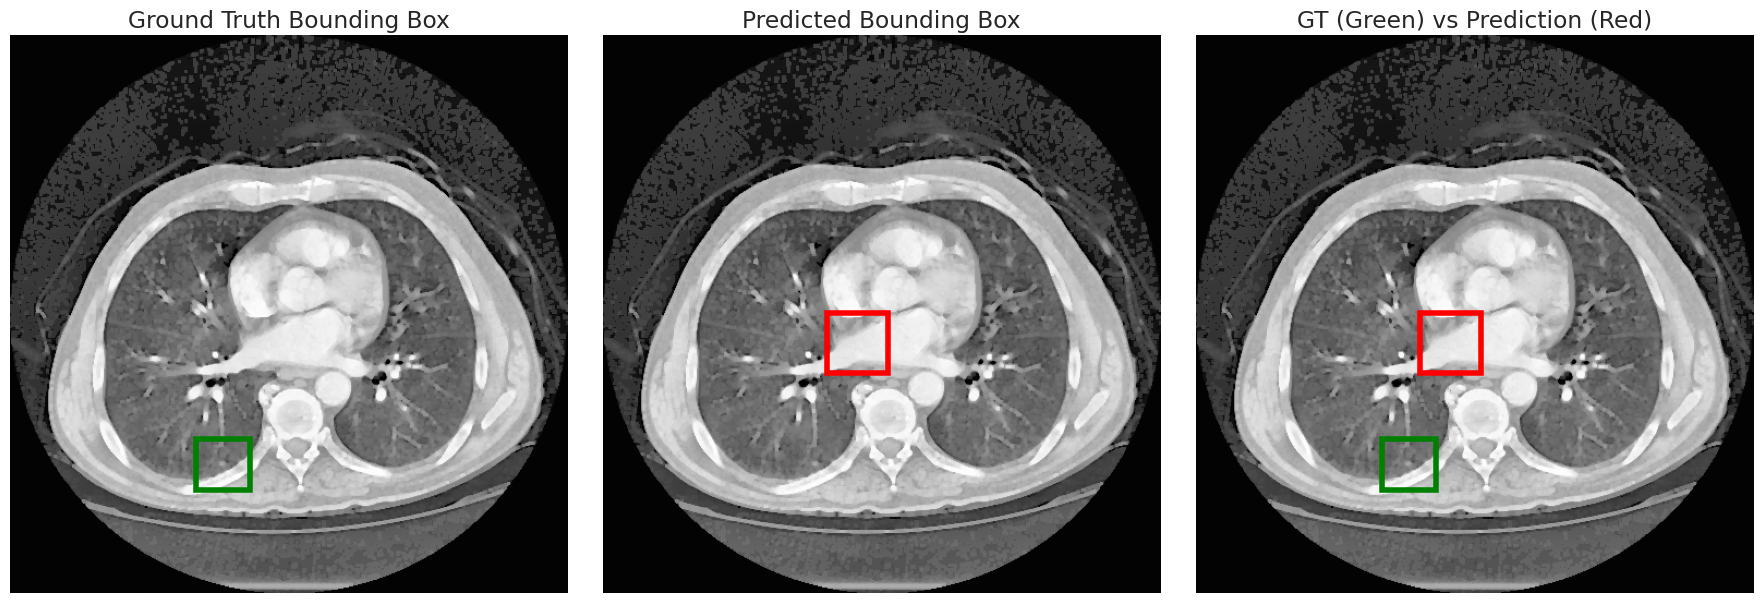

258/258 ━━━━━━━━━━━━━━━━━━━━ 42s 164ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0202 - val_mse: 0.0202 - learning_rate: 0.0010
Epoch 17/200
229/258 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 0.0215 - mse: 0.0215

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduceLROnPlateau, plot_callback, viz_callback],
    shuffle = True,
    verbose=1
).history

### Save model

In [ ]:
with strategy.scope():
    time_now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S') 
    model.save(f'/kaggle/working/localization_{time_now}.keras')

## **MODEL EVALUATION**

In [ ]:
# Plot training and validation loss
history = model_fit.history 
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['val_mse'], label='Training IoU', alpha=.8)
plt.plot(history['val_iou'], label='Validation IoU', alpha=.8)
plt.title('IoU')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
train_preds = model.predict(full_slices)

In [ ]:
import random

# for i in random.sample(range(len(train_preds)), k=20): 
for i in range(100):
    fig, ax = plt.subplots()
    ax.imshow(full_slices[i], cmap='gray')
    rect_gt = Rectangle((bboxes[i,0], bboxes[i,1]), bboxes[i,2], bboxes[i,3], linewidth=1, facecolor='none', edgecolor='g')
    rect_pred = Rectangle((train_preds[i,0], train_preds[i,1]), train_preds[i,2], train_preds[i,3], linewidth=1, facecolor='none', edgecolor='r')
    ax.add_patch(rect_gt)
    ax.add_patch(rect_pred)
    plt.show()

## **MODEL EXPLANATION**